In [1]:
# @itsvenu_
# Combine SOM+ANN

# detect frauds from SOM
# then use these results to get probabilities of each customer
# being a fraud

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score
from minisom import MiniSom
from pylab import bone, colorbar, pcolor, plot, show

from keras.models import Sequential
from keras.layers import Dense

In [3]:
dat = pd.read_csv('../../data-dl/Credit_Card_Applications.csv')
dat.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [4]:
X = dat.iloc[:, :-1].values
Y = dat.iloc[:, -1].values

In [6]:
# feature scaling

sc = MinMaxScaler(feature_range=(0,1))
X = sc.fit_transform(X)

In [8]:
# SOM

som = MiniSom(x=10, y=10, input_len= 15, sigma= 1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)

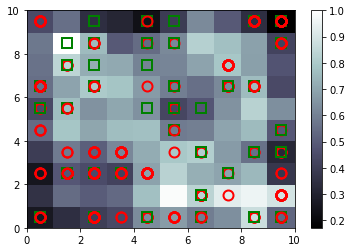

In [11]:
# viz
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[Y[i]],
         markeredgecolor = colors[Y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()

In [14]:
mappings = som.win_map(X)
mappings[(1, 8)]

[array([0.48842545, 0.        , 0.11909774, 0.41071429, 0.        ,
        0.30769231, 0.25      , 0.        , 1.        , 1.        ,
        0.1641791 , 1.        , 0.5       , 0.        , 0.        ]),
 array([0.22236104, 0.        , 0.07774436, 0.33035714, 0.        ,
        0.53846154, 0.375     , 0.03508772, 1.        , 1.        ,
        0.05970149, 1.        , 0.5       , 0.04      , 0.005     ]),
 array([0.62071686, 0.        , 0.14541353, 0.02821429, 0.        ,
        0.76923077, 0.375     , 0.05263158, 1.        , 1.        ,
        0.02985075, 1.        , 0.5       , 0.04      , 0.004     ])]

In [16]:
frauds = np.concatenate((mappings[(1,8)], mappings[(9,1)]), axis = 0)
frauds = sc.inverse_transform(frauds)

In [18]:
len(frauds)

18

In [19]:
customers = dat.iloc[:, 1:].values

In [20]:
customers.shape

(690, 15)

In [23]:
is_fraud = np.zeros(len(dat))
is_fraud[:5]

array([0., 0., 0., 0., 0.])

In [24]:
for i in range(len(dat)):
    if dat.iloc[i,0] in frauds:
        is_fraud[i] = 1


In [31]:
# train ANN

sc_ann = StandardScaler()
customers = sc_ann.fit_transform(customers)

In [33]:
annClassifier = Sequential()

In [34]:
# input layer
annClassifier.add(Dense(units=2, kernel_initializer='uniform',
                       activation='relu', input_dim=15))


# output layer
annClassifier.add(Dense(units=1, kernel_initializer='uniform',
                       activation='sigmoid'))

In [35]:
annClassifier.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [36]:
annClassifier.fit(customers, is_fraud, batch_size=1, epochs=2)

Epoch 1/2
690/690 [==============================] - 1s 900us/step - loss: 0.4944 - accuracy: 0.9667
Epoch 2/2
690/690 [==============================] - 1s 814us/step - loss: 0.1548 - accuracy: 0.9739


In [38]:
# testing
Y_pred = annClassifier.predict(customers)

In [41]:
# add customer ids
Y_pred = np.concatenate((dat.iloc[:, 0:1].values, Y_pred), axis = 1)

In [42]:
Y_pred = Y_pred[Y_pred[:, 1].argsort()]

In [44]:
Y_pred[:-5]

array([[1.57997850e+07, 2.15631723e-03],
       [1.56548590e+07, 3.02124023e-03],
       [1.57250280e+07, 4.10646200e-03],
       ...,
       [1.57363990e+07, 1.97240949e-01],
       [1.57499640e+07, 1.97849780e-01],
       [1.56389830e+07, 2.13044405e-01]])